In [19]:
#0 Installations

In [20]:
!pip install torch torchvision torchaudio
!pip install transformers sentence-transformers
!pip install chromadb
!pip install "numpy<2" #to solve compatability error with sentence-transformers

In [21]:
#1 Import functions 

In [22]:
from sentence_transformers import SentenceTransformer, util 
import torch
import pandas as pd
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import chromadb

In [23]:
#2 Import the pre-trained CLIP model using SentenceTransformer

In [24]:
model = SentenceTransformer('clip-ViT-B-32')

In [14]:
#3 Establish ChromaDB connection 

In [25]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the API key and other details from environment variables
api_key = os.getenv("CHROMA_API_KEY")
tenant_id = os.getenv("CHROMA_TENANT")
database_name = os.getenv("CHROMA_DATABASE")

# Check if the variables were loaded correctly
if not api_key:
    print("Error: API key not found. Make sure it's in your .env file.")
else:
    # Use the variables to create the client
    client = chromadb.CloudClient(
        api_key=api_key,
        tenant=tenant_id,
        database=database_name
    )
    print("ChromaDB client initialized successfully!")

ChromaDB client initialized successfully!


In [26]:
#4 Create embeddings

In [18]:
# Load the dataset from Github main branch  

def load_local_data():
    """Load the dataframe from the Github CSV file in the 'sample1000BALANCED' directory."""
    # Use the new relative path to the CSV file
    df = pd.read_csv("sample1000BALANCED/data_sampling1000_topstyles10.csv")
    return df

# Replace the previous line with the new function call
df = load_local_data()


# Get or create a collection. This is where your embeddings will live.
# The name "wikiart_embeddings" is an arbitrary name you choose.
collection = client.get_or_create_collection(name="wikiart_embeddings")


# Select a small number of images to work with / batch it 
small_df = df[500:650]

# Create a list to store the image embeddings
image_embeddings = []

# Loop through the images, download them, and create their embeddings
for index, row in small_df.iterrows():
    try:
        image_url = row['img']
        image = Image.open(requests.get(image_url, stream=True).raw)
        
        # Use the CLIP model to encode the image.
        # The SentenceTransformer library's encode method automatically handles preprocessing.
        embedding = model.encode(image)
        
        # add the embedding to ChromaDB
        collection.add(
            embeddings=[embedding.tolist()],
            documents=[row['file_name']],
            metadatas=[{"artist": row['artist'], "style": row['style'], "url": image_url, "file_name": row['file_name']}],
            ids=[str(index)]
        )
        print(f"Processed and added image {index} to ChromaDB.")

    except Exception as e:
        print(f"Could not process image at URL {image_url}: {e}")

Processed and added image 1 to ChromaDB.
Processed and added image 2 to ChromaDB.
Processed and added image 3 to ChromaDB.
Processed and added image 4 to ChromaDB.
Processed and added image 5 to ChromaDB.
Processed and added image 6 to ChromaDB.
Processed and added image 7 to ChromaDB.
Processed and added image 8 to ChromaDB.
Processed and added image 9 to ChromaDB.
Processed and added image 10 to ChromaDB.
Processed and added image 11 to ChromaDB.
Processed and added image 12 to ChromaDB.
Processed and added image 13 to ChromaDB.
Processed and added image 14 to ChromaDB.
Processed and added image 15 to ChromaDB.
Processed and added image 16 to ChromaDB.
Processed and added image 17 to ChromaDB.
Processed and added image 18 to ChromaDB.
Processed and added image 19 to ChromaDB.
Processed and added image 20 to ChromaDB.
Processed and added image 21 to ChromaDB.
Processed and added image 22 to ChromaDB.
Processed and added image 23 to ChromaDB.
Processed and added image 24 to ChromaDB.
P

In [39]:
#3) Load, search and print most similar images

In [40]:
# (0) Define the local query images
# Create a list of paths to your four locally downloaded images.
local_query_images = [
    "raw_data/Images to try/Paul_Cézanne_-_The_Basket_of_Apples.jpg",
    "raw_data/Images to try/Piet_Mondriaan,_1942_-_New_York_City_I.jpg",
    "raw_data/Images to try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
    "raw_data/Images to try/Two_Young_Girls_at_the_Piano_MET_rl.jpg"
]

# (1) Load each query image and find its embedding by looping through the list of image paths.
for query_image_path in local_query_images:
    try:
        # Load the image from the local file path
        query_image = Image.open(query_image_path)
        
        # Use the CLIP model to encode the image
        query_embedding = model.encode(query_image).tolist() 
        
        # Use ChromaDB to find the most similar images and get top5 most similar results 
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=5, # Since the query image is not in the database, we ask for exactly 5.
        )

        # Print the results for the current query image
        print("—" * 50)
        print(f"Querying with local image: {os.path.basename(query_image_path)}\n")
        print("Top 10 most similar images:")

        # We now loop through all 5 results as the local image is not in the DB
        for i in range(5): 
            result_id = results['ids'][0][i]
            metadata = results['metadatas'][0][i]
            distance = results['distances'][0][i]

            print(f"Rank {i+1}:")
            print(f"  ID: {result_id}")
            print(f"  File Name: {metadata['file_name']}")
            print(f"  Artist: {metadata['artist']}")
            print(f"  Similarity Score: {distance:.4f}")
        
    except Exception as e:
        print(f"Error processing image {query_image_path}: {e}")

Query image from index 6: 7-ravenna-cappella-arcivescovile-165.jpg

Top 10 most similar images (excluding the query image):
Rank 1:
  ID: 1
  File Name: 1-ravenna-cappella-arcivescovile-167.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 18.4850
Rank 2:
  ID: 8
  File Name: 8-soffitto-del-mausoleo-di-galla-placidia.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 25.0832
Rank 3:
  ID: 20
  File Name: 20-mausoleo-di-galla-placidia-ravenna-14088243617.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 33.5756
Rank 4:
  ID: 11
  File Name: 11-martyrdom-of-st-lawrence.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 33.6840
Rank 5:
  ID: 18
  File Name: 18-ravenna-mausoleo-di-galla-placidia-34.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 34.4864
Rank 6:
  ID: 25
  File Name: 25-galla-placidia-interno-2-1.jpg
  Artist: Byzantine Mosaics
  Similarity Score: 35.8079
Rank 7:
  ID: 48
  File Name: 48-st-vitalis-archangel-jesus-christ-second-archangel-and-bishop-of-ravenna-eccl

In [41]:
#4) Display the images

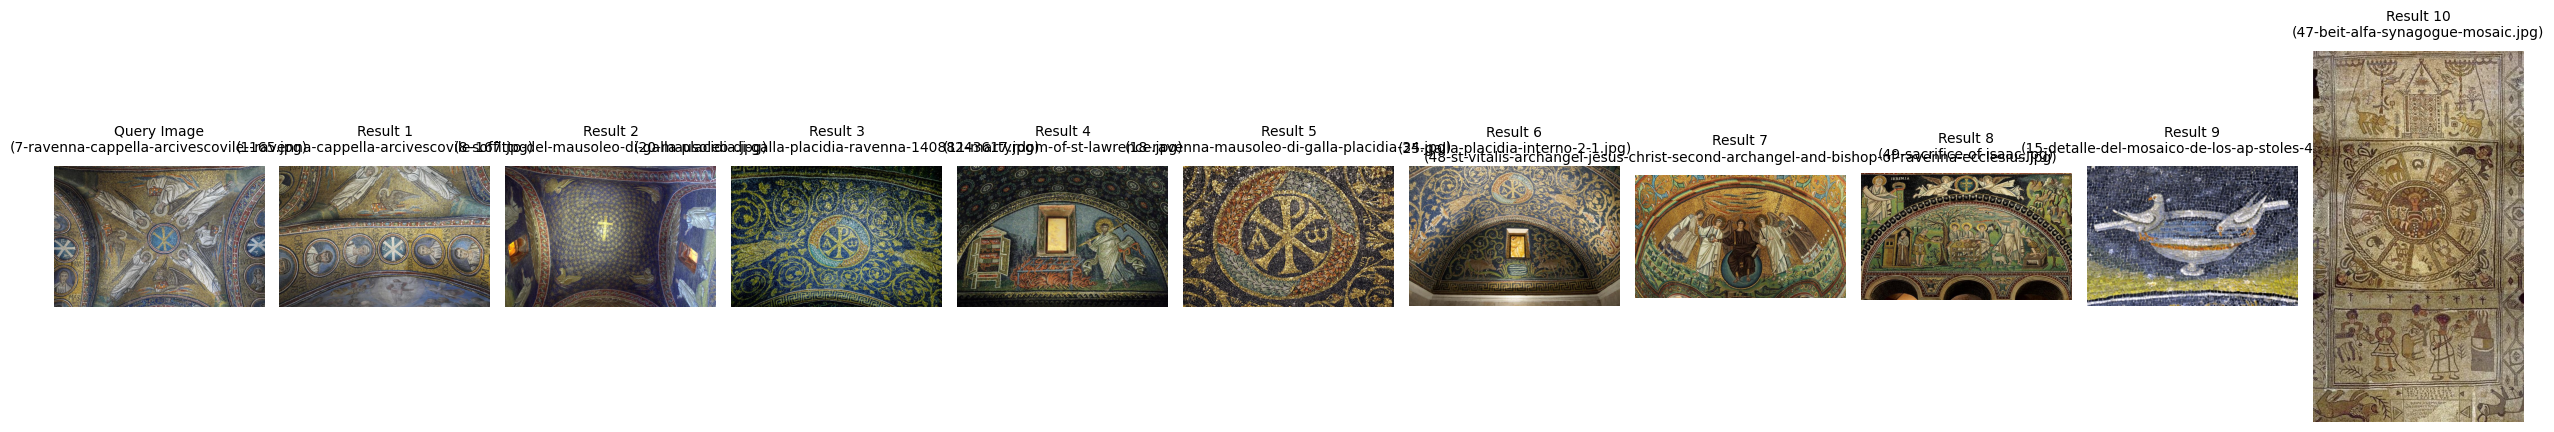

In [42]:
def show_images(image_urls, titles):
    # Adjust subplot size to accommodate 11 images (query + 10 results)
    fig, axes = plt.subplots(1, len(image_urls), figsize=(25, 6))
    if len(image_urls) == 1:
        axes = [axes]

    for ax, url, title in zip(axes, image_urls, titles):
        try:
            image = Image.open(requests.get(url, stream=True).raw)
            ax.imshow(image)
            ax.set_title(title, fontsize=10, pad=10)
            ax.axis('off')
        except Exception as e:
            print(f"Could not display image at {url}: {e}")

    plt.tight_layout()
    plt.show()

# Get the URLs and file names for the top 10 results from the ChromaDB results
result_urls = [metadata['url'] for metadata in results['metadatas'][0][1:]]
result_file_names = [metadata['file_name'] for metadata in results['metadatas'][0][1:]]

# Prepare titles for visualization, including the file names
result_titles = [f"Result {i+1}\n({name})" for i, name in enumerate(result_file_names)]

# Add the query image and its title to the beginning of the lists
query_url = small_df.iloc[query_index]['img']
query_file_name = small_df.iloc[query_index]['file_name']
all_urls = [query_url] + result_urls
all_titles = [f"Query Image\n({query_file_name})"] + result_titles

# Visualize the images!
show_images(all_urls, all_titles)